# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [55]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(alternate_sign=False, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [56]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [57]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 6444, 'TN': 57436, 'FP': 57218, 'FN': 6558, 'Accuracy': 0.5004073447389861, 'Precision': 0.10122207910527473, 'Recall': 0.49561605906783573, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [58]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12992, 'TN': 114636, 'FP': 18, 'FN': 10, 'Accuracy': 0.9997806605251613, 'Precision': 0.9986164488854727, 'Recall': 0.9992308875557606, 'desc': 'svm_train'}


### MODEL: logistic regression

In [59]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12982, 'TN': 114641, 'FP': 13, 'FN': 20, 'Accuracy': 0.9997414927617974, 'Precision': 0.9989996152366295, 'Recall': 0.9984617751115213, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12996, 'TN': 113217, 'FP': 1437, 'FN': 6, 'Accuracy': 0.9886961834931378, 'Precision': 0.9004364996882145, 'Recall': 0.9995385325334564, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [61]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12984, 'TN': 114639, 'FP': 15, 'FN': 18, 'Accuracy': 0.9997414927617974, 'Precision': 0.9988460650819294, 'Recall': 0.9986155976003692, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [62]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12990, 'TN': 114645, 'FP': 9, 'FN': 12, 'Accuracy': 0.9998354953938711, 'Precision': 0.9993076390491576, 'Recall': 0.9990770650669127, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 0, 'TN': 114654, 'FP': 0, 'FN': 13002, 'Accuracy': 0.8981481481481481, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/isabelstoddart/Desktop/ML/myWork/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

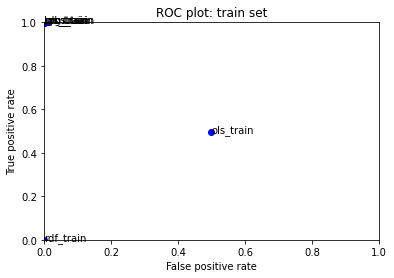

In [64]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [65]:
ols_predictions = ols.predict(X_train)

In [66]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
3
Your opinion is obviously baised. HERE.
Only place i could find it. -
* * * * * * * * * 
46
I contest the reason given is completely false, and whoever requested it deliberately misused the blocking process.
* * * * * * * * * 
138
This article is biased against 97.7.
* * * * * * * * * 
156
Deleted American Criminal category 

It's incredible to me that the facts of this article might lead some misguided soul to think this is what the American Criminal Category is for.  There's a lively discussion at the category's talk page about what should be in the category, but even the most expansive reading of the category doesn't countenance this.
* * * * * * * * * 
164
Consensus
Consensus is defacato percent and numbers, regardless of how much people pretend it isn't. See Deskana's response on his page.
* * * * * * * * * 
174
"

 Unreferenced 

What in particular is unreferenced?  

Easy way to find citations: Check out the external links, press F3, type in citati

3389
your mum know's nothin bout chechoslovakia
* * * * * * * * * 
3408
(2) cannot be grouped into a general rule
* * * * * * * * * 
3481
Simple explanation
Wikipedia is an encyclopedia. It has articles. It has User Pages for people who work on the articles. The User Pages are for talking about the articles.

This is not myspace. You don't use it to send messages to your friends, or chat, or blog. This is not the place for that.
* * * * * * * * * 
3561
Please stop your disruptive editing. If your vandalism continues, you will be blocked from editing Wikipedia.  —αἰτίας •discussion• 
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices.
* * * * * * * * * 
3581
Do let me know of any important plot details on Shadow Hunters (without ruining the plot for me! ) ). If my memory of your SC Legacy forum flag serves correctly, you're in Canada so you're going to be able to get hold of it quicker than 

6225
"

 Well, my edits are not being reflected on the wiki server. 

Must just be a coincidence ... Thanks. ☘☘ craic "
* * * * * * * * * 
6244
"

 Swat Valley redirect 

Swat Valley redirects here. But I think people generally use the term ""Swat Valley"" to mean Swat District, not the river. How would people feel about changing the redirect so that it points to the district, instead of the river?  (talk) "
* * * * * * * * * 
6246
Thanks Joshua! Just a scratch at the surface. I also looked at the writings on your page. Pretty extensive work! Good job )
* * * * * * * * * 
6294
The name Haliburton Wolves was chosen for the page name which is the name of the Junior A Hockey club that I am creating this page for.  I can certainly change the user name - however I have not seen how to name the page Haliburton Wolves Tier II Junior A Hockey.
* * * * * * * * * 
6338
hello

Thank you for making Roby Young a page. He was a wonderful player. Just for your general info, ilyhg user is my best fire

9361
"

""Strong encrypted F2F networks will mainly use strong symmetric encryption (in particular, the only theoretically secure one-time pad) for every link.""
Who ever wrote this article could do with a brush up on practical cryptography (no..not the book). OTP is pretty unpractical here."
* * * * * * * * * 
9362
"

then long-time girlfriend Tracy Wilhelmy I think this hyphen is misplaced. ""then"" is a modifier, and ""longtime"" is an adjective itself.

The position had opened up after assistant coach Jamal Meeks resigned after being arrested on solicitation  and drug charges. (He was later acquitted.) Clunky. ,of which he was later acquitted would seem to flow better.

Collier was in complete agreement Wordy. Why not just Collier agreed ?

Butler was awarded the 7 seed in the East Regional. They beat tenth-seeded South Alabama 81–61 in the opening round Number usage certainly needs to be consistent when they're this close together. Also, the ""opening round"" is the play-in game. 

11878
I agree with Kishorekumar.  Many forces have declared unilateral ceasefires when winning a war, such as the US-led coalition in the First Gulf War of 1991.  The US had completely dislodged the Iraqis from Kuwait, routed their divisions, and could have easily marched on Baghdad, but decided to withdraw to pre-war boundaries after accomplishing their limited strategic goals.  Cheers,
* * * * * * * * * 
11984
"

Torrents are not limited to 50GB, as the article says ""as large as 50GB"" (or so), there are torrents that are 200GB + 24.129.237.34  "
* * * * * * * * * 
12046
Before we end up arguing, I was trying to find the Eddie Guerrero Tribute Show from last November on Wikipedia. It was on their in September. Now it's deleted. One rule doesn't apply for one tribute show compared to another tribute show. Reply.
* * * * * * * * * 
12077
"::::::Whatever, my policy is that I think that it needs to be edited then I will edit it.  And I think that if someone wants to make a major edit th

14717
Stub? 

Is A Bad Wind Blows in My Heart a stub now or not?
* * * * * * * * * 
14844
Violation of Wikipedia Terms
Note: Anyone who modifies the format of my page will be subject to Wikipedia's Spam Policy. The page is now under the watch of Wikipedia.

Also, a note to , you have been officially reported to Wikipedia. An Wikipedia:edit war is not the appropriate way to conduct yourself on Wikipedia.

May I also direct everyone to reading the Three-Revert Rule, which allows you to be banned for a minimum of 24-hours for reverting more than three times in the form of vandalism.
* * * * * * * * * 
14850
I am going to break my own personal policy of not commenting to unsigned comments: if you want me to respond to a comment, sign it. Nlu (talk) 

Your message makes no sense, and your personal policy is immaterial to your role and responsibilities as an Administor. What do you care who the comment is from? Dont hide behind your silly personal policy.
* * * * * * * * * 
14918
Shared IP
.

17522
Re: Leilapk/anon IP. The sources you linked did refer to an Iranian wine called Shiraz but doesn't specify it as being from the Syrah Grape and in fact the Hugh Johnson Vintage: Story of Wine ref does describe as the same Shirazi wine which numerous reliable sources describe as being made in Shiraz. (And if you notice, the same Story of Wine ref you added is actually already being used in the Shirazi wine article. Additionally there are numerous reliable sources in this article, including links to the DNA evidence, that conclusively show that the Syrah wine grape originated in France. No one is denying that a Shirazi wine was made in the Iranian/Persian city of Shiraz and, indeed, we have an article dedicated to the subject and make reference to that article repeatedly in the Syrah article. But the abundance of evidence shows that the Shirazi wine (which was likely made from Trebbiano) and today modern Syrahs/Shirazes are different wines. Cheese/Wine
* * * * * * * * * 
17608
Also

20835
Totally irrelevant, ego-driven drivel 

And, for the record, NO, this is not a personal attack, just an observation on the total pointlessness of this entry...

Maybe we should all put our CV's on Wikipedia, but I thought that Wiki was attempting to become a credible medium of encyclopeadic information on the Internet, not for self-publicity seeking ego merchants to paste up their life story and that of their woefully un-spectacular personal and family histories.

This entire entry is no more suitable for a page than my life's contribution to the study of Ethiopian-styles of ballroom dancing. It belongs on a Wiki personal page and no more.

Considering that my family tree can be traced to before the Norman invasion of England and I hold an hereditary title (which was once owned by Elizabeth I and Francis Bacon) maybe I could start posting up my little life story and my g-g-g-g-g-g-g-g-g-g-g-g-g-g-uncles and g-g-g-g-g-g-g-g-g-g-g-g-g-grand-daddies and which castles they built, etc

23813
Vehicles will be in MW2
M16 will return, using stopping power will only be OHK at head, neck, and torso (abdomen, limbs, and hands/feet will not)
Ak47 and M4 will return, unknown if there are any changes
M40 will return, ACOG damage boost will be fixed
Scorpion, P90, M21, R700, G3, G360 will not return
There are more unknown weapons that will not return
New sniper rifle: SR25M (United states forces)
New Assault rifle: Diemeco C8 (Canadian forces M4 equivelant)
New Assault rifle: L85A2 (United Kingdom forces)
Total weapons in multiplayer are said to be around 35
Favourite Modern warfare 1 maps will return
Helicopters, air strikes, UAV will return
Red dot sightings will come in different shapes for multiplayer (circular, square, original)
Snipers will have special grass camouflage (As seen in Modern warfare 1’s campaign)
All perks will return from MW except eavesdrop and others will be altered
All gametypes will return from MW and all will have hardcore versions
New gametype: Secur

26498
"

Berwickshire
I have added the category ""Berwickshire"". I hope people don't mind this, I realise it is no longer considered to be in Berwickshire, but it is relevant to it for several reasons, including the fact that the county is named after the town.  "
* * * * * * * * * 
26533
"

Baseball

Thanks so much for improving my ""critical analysis"" section in the Baseball article.  You preserved the essence of what I was trying to say, and you did a great job.  "
* * * * * * * * * 
26543
Re: Edit Warring 

The page in question was deleted as part of a broad WP:POINT campaign by
* * * * * * * * * 
26587
Wikipedia is an encyclopedia, not a business listing directory, and is not for advertising or promotion of any kind
* * * * * * * * * 
26669
File:CALDAY CCF 2005.jpg listed for deletion 
An image or media file that you uploaded or altered, File:CALDAY CCF 2005.jpg, has been listed at Wikipedia:Images and media for deletion. Please see the discussion to see why this is (you may hav

29570
"

 Talk:Die Young (Ke$ha song) 

Your request at Talk:Die Young (Ke$ha song) seems reasonable, but will require and admin to make the change. I have made a note at the admin notice board Wikipedia:Administrators%27_noticeboard#Change_of_redirect_of_a_locked_page if you would like to add additional rationale.  The Red Pen of Doom "
* * * * * * * * * 
29583
Ancón
Done. — 0918 • 2005-10-23 23:10
* * * * * * * * * 
29592
Congratulations on your new GA 

I passed Astaroth (Soulcalibur) as a GA. Good work, man. By the way, would you mind reviewing Lego Star Wars II: The Original Trilogy for me? It's been at GAN for about a week.
* * * * * * * * * 
29616
Hmm, I was about to show there is no consensus. Furthermore, if we go around and delete every perceived minor character, there will be quite a ruckus. I submit that people don't like Dallas for some reason and that is why they keep this up.
* * * * * * * * * 
29736
yo mama yo mama yo mama
* * * * * * * * * 
29763
"

""could fit into a 

32558
discuss is Wikipedia:Articles for deletion/Yvonne Koay
* * * * * * * * * 
32567
"
In the Plot section, Mike de Wolf and Horace Hackett should be referred to by either their last name or first name. You refer to the former by his first name and the latter by his last name.
In the Plot section: Up there - God? Is this an em dash or en dash?
In the Genres section: Roland J. Green of the Chicago Sun-Times also described the work as a ""classic"", and wrote positively of Hubbard's novel Final Blackout. I don't think that Final Blackout is relevant here.
In the Reception section: ""Typewriter in the Sky, which first appeared in Unknown in 1940. is widely considered to be one of his best works."" You may have misquoted this because the period in the middle of the sentence seems odd.
In the Influence section: I bet if L. Ron Hubbard had written Purple Rose of Cairo they'd have given it a Hugo ... I mean, it is sort of a hip, updated version of Typewriter in the Sky. Is Purple Rose of Cai

35415
"

Hi benne
I will probably be banned by plyambert, he has changed everything to assyrian, and is trying to undermine the aramean article. I dont know why there arent any other admin that can tell him to stop. Im currently trying to show him how hard it is when someone just changes an article without discussing it. (the article bethnahrin and aramean). and after 3 reverts he threatend to bann me (he shows where i live and how he identifies me ""syriac""), I believe that it is some kind of mark on that he know some thing about me, I dont really understand him, he is pretty radical. And Im actually starting to wounder what his real intentions are.
oh well I really think that this is waste of time. If you are still intersted on the project I spoke of through the email, then i would be more then happy to begin. best wishes// "
* * * * * * * * * 
35533
"

 Please do not vandalize pages, as you did with this edit to Toy. If you continue to do so, you will be blocked from editing.    "


38439
Please tell me where you had the feeling I talked about you. I tried not to mention your name.
* * * * * * * * * 
38507
Important 

I left the following note on the Need for speed talk page. I have copied it here because it is important that you know about it.

It is important that you read WP:OWN. If you do not you may find you current course of actions may lead towards you being classed as a disruptive editor, or worse. Policy is VERY import on Wikipedia. I urge you in the strongest terms possible to read WP:OWN. -
* * * * * * * * * 
38544
"

Fine, but keep in mind that this is not solely a matter of being NPOV- this is also a matter of accuracy.  The Eastern Catholic Churches that are in communion with the Vatican are not properly referred to by the term ""Roman Catholic Chruch""- only those who practice the Latin or Western Rite are.  Take a look at this FAQ on Eastern Catholiscim to see how the term is properly used: .  The only truely accurate way to refer to the church hea

41353
"
I actually disagree with you, firstly whilst it may be the case that people are not required to explain their actions its merely good manners to do so and the request 'to do so' is that which makes good pages via clear and fair debates and discussions, hence the existance of these areas! Secondly a picture that represents a page should be that of a tidy and well presented image (regardless of the inane issues you talk about ie, weight - which should not even be an issue unless your ignorance truly knows no bounds!) and be reflective of what the person on the page is (in Kellys case a singer). But clearly I am wasting my time on this clique of a page (one of which has zero interest in any kind of standard) and those clearly have no interest in the thoughts of others regardless making your introduction into ""discussions"" irrelevant and pointless, bearing in mind I already started that part. Do what ever you like, I am done wasting my time, the page can look a mess!   "
* * * * 

45069
"

 Hi there! Thank you for your querie about the Humanistic teachings of Nichiren Buddhism. Let me start by saying that the title ""Humanistic Buddhism"" is rather sematically weak: because there are no 2 types of Buddhism: one Humanistic and another non-Humanistic. I think we should alter the title into ""Buddhist Humanism"". If you trace the word Humanism you'll find various views: Christian Humanism, secular Humanism...etc... and adding the term ""Buddhist Humanism"" is appropriate. 

 Secondly, the term Humanistic Buddhism or Buddhist Humanism, whether in China or Japan or the USA, is based on the Buddha's teachings - in particular the teachings of the Lotus Sutra. (The article mentions this clearly). The Lotus Sutra - of course - is not a private property of a certain temple or nation (Chinese, Japanese etc...) Buddhism of the Lotus Sutra is a universal teaching for all Humanity.

Historically, it was TienTai of China who placed the Lotus Sutra as the highest of the Buddha'

48009
Please stop 

I am assuming that the articles you are creating are of you and your friends.  12 year old soccer players and the club that they play in are almost always going to fail to meet our notability criteria.  If you do not stop creating articles like this you will be blocked from editing.  Also, do not use multiple accounts, such as .
* * * * * * * * * 
48032
I am inclined to agree with the revert.  I believe you are technically correct, but I do not think the original wording is sufficiently misleading to justify the extra sentence.  It's a judgment call, of course.  That's just my opinion.
* * * * * * * * * 
48089
Keep on setting block traps as it obviously represents an enjoyment for you. But I will never ask for any measures against anyone, including you. I will maintain the record of your violations of WP regulations, in case some admins want to hold you responsible for disrespecting WP.
* * * * * * * * * 
48132
Block 

Please remove the
* * * * * * * * * 
48175
I am

51076
"
It's ""required"" by this MOS because of the links that it provides in the top row; it's far from being just a navbox.    "
* * * * * * * * * 
51165
Charles Mccarthy
Is this Charles McCarthy stuff vanity material or AS promotion???
* * * * * * * * * 
51187
It was Unfair that some of the senior editor of West Bengal Kolkata are not allowing latest pics to be added in Kolkata wiki page.  

It's a open forum where every one has a right to speak up and post. I was recently blocked by One of the senior editor of Kolkata Wikipedia forum from posting pic's to Kolkata wiki page.

I don't know why it is that... The Kolkata wiki page is always having the same outdated pic's.

Last week on 9th May 2013... When I posted some pic's of Kolkata Economy adding IT Infrastructure pic's of Unitech Kolkata, Technopolis, DLF (IBM), Wipro . Some of the senior Kolkata wikipedians deliberately removed them giving useless excuses.

Which I think is very unfair...

So, Do I need to make my own page now 

54384
No problem at all Jeppiz ;-) I'm sure we can work together very well in the future.
* * * * * * * * * 
54387
"
Talkback

 One ping only "
* * * * * * * * * 
54485
Thanks, Haf! Mind you, I'm expecting ten FPs in the next two days, so it's probably for the best that I've started early. =)
* * * * * * * * * 
54500
That’s not what A1 says: Please read WP:A1. It says nothing about “below stub-class” (whatever that may mean). WP:Stub deals at length with what may be too much for stub class, but so far as I can see, it says nothing about what may be too little. If you want to change the standard to include something about articles below stub-class, you should propose it at WP:CSD.
I will grant you that A7 may have appropriate for this article but not A1. — t c
* * * * * * * * * 
54514
Good luck with your meetings! )
* * * * * * * * * 
54524
Yeah, you got some very solid support this go-round, things will probably go better next time. - Dank (push to talk)
* * * * * * * * * 
54540
"
 Res

57878
"

Thanks Ral315. I don't know what you enjoyed about it so much, but thanks all the same.  

Oh, I like Ann, you see, and I just love it when people post information about her. Athough, as an admin I have to pretend not to like it. I do really though. ;-) I like it so much 315 

Ral, its nice of you to say that. I know, as a 15 yoear old teenager your imagination may run wild sometimes, but you need to keep a handle on things. Thanks for your input.  "
* * * * * * * * * 
57904
MIDDLE NAME? 
A woman's maiden name is NEVER a middle name.  The surname section is purposefully misleading and should not appear in the article.  A week prior her name was different in the credits but that's conveniently not reflected in the article.  The section is grandstanding by Dougie and not relevant to the content of the article.
* * * * * * * * * 
57931
and congratulations on your re-election
* * * * * * * * * 
58016
And you still have no interest in correcting the last sentence despite making a b

60866
As I have already admit , that was a mistake, and is undone. What we are discussing here is whether Chinese the written language should be included in this list. We'll also have to decide which article should be linked to, if it is decided to be included. — ntnood
* * * * * * * * * 
60879
BTW, why would you come here to talk about me, but tag in others, including non-admins?
* * * * * * * * * 
60902
Thank you for experimenting with the page Yellow-spotted tropical night lizard on Wikipedia. Your test worked, and it has been reverted or removed. Please use the sandbox for any other tests you may want to do. Take a look at the welcome page to learn more about contributing to our encyclopedia. '''' (talk'')
* * * * * * * * * 
60912
"Hello, welcome to my talk page!

If you want to leave a message, please do it at the bottom and using headings, for better formatting. You can do that by simply pressing the plus sign (+) on the top of this page. And don't forget to sign your messages by

63680
"
I mean really, they are a new editor that appeared to be editing on good faith, adding information that was included in an already used source. Their edit summary didn't show any hostility, so you should not retaliate with any. Odds are, they haven't even looked at their talk page, so your comment won't be read anyways. If the act of reverting dubious additions from new users is stressing you out, maybe this is a problem you should see about solving, instead of acting like it is a personal attack on you. Plus, Antoshi already warned them on their talkpage, and they have not added anything since, showing that maybe they have listened to the advice. Your threat was completely unnecessary. Maybe explaining to them that the information has already been added, but rejected, and why would be a better option. 
WP:AGF and WP:BITE are very important. Like I said in the dispute resolution page, I don't mean to make any enemies. I think you are an amazing editor that does a lot for the pr

66316
"

 Wiki Cake 

  has given you a WikiCake! WikiCakes promote WikiLove and hopefully this one has made your day a little better. Spread the WikiLove by giving someone else a cake, whether it be someone you have had disagreements with in the past or a good friend. Bon appetit! 

Spread the tastiness of cakes by adding  to their talk page with a friendly message.
  "
* * * * * * * * * 
66346
Yeah sorry about that mistake. I have since corrected it.
* * * * * * * * * 
66350
I will revert to original photograph if there are no objections posted.
* * * * * * * * * 
66410
"

 Weasel wording 

I continue to have concerns about this article in that it attributes opinions to some unspecified ""French monarchists"" without saying who, exactly, they are.  The position attributed to them is quite preposterous and so really requires some serious sourcing.  Who, exactly, are these ""Legitimists"" and if they are a very fringe group, perhaps merely of hobbyists or enthusiasts of some kind, we s

69215
"

WikiProjects interested in ""Militant Atheism""
Could you please explain more about why you have recently removed several WikiProjects mentioned as being interested in the article ""Militant atheism""? The article discusses issues which clearly involve Christianity, and other religions, so I think they could be restored.   "
* * * * * * * * * 
69234
"

Map

Ok, fz, I see that you changed map but it still cannot be here because it is incorrect. The Slavs were majority in this whole area while Avars were just ruling caste that ruled over Slavs but did not formed majority in the area. In another words, map is nothing but science fiction.  "
* * * * * * * * * 
69257
and assigning his own names and opinions to things and reverting any attempt to repair that.
* * * * * * * * * 
69412
Just discovered I have been insulted for raising this question. Have posted a defence at [] - Testbed
* * * * * * * * * 
69539
by being the easiest way, and
* * * * * * * * * 
69645
If Flickr guy did so

72131
"
1) Organisations also count as things.
2) The section you quote from WP:NAME is in the section titled ""Use English words"", which goes on to say ""Sometimes the usual English version will differ somewhat from the local form as in Franz Josef Strauss; and rarely, as with Mount Everest, it will be completely different."" This is clearly a case where the ""usual English version"" differs somewhat.
3) Wikipedia:Naming conventions (political parties) carries several exceptions: the third exception is ""Parties whose name is more commonly known by acronyms than their full name in international newsmedia."" Since GPV is more commonly known by its acronym, this naming convention does not apply.
4) There is no problem with ambiguity, since there are no other topics in Wikipedia that carry the name GPV.  Even if there were, this article would then be named GPV (political party) to disambiguate them.
In conclusion: please read naming conventions in full before quoting them to me.  Also, 

75164
REDIRECT Talk:Guerillas in the Mist (CSI: Miami)
* * * * * * * * * 
75255
On East Lake Square Mall 

It was a mall of local significance which closed in 1998. Take a look at the article List of defunct shopping malls in which the link was also there. If you want to speed delete this, you will have to look at the other defunct mall articles and put tags on it as well. Thank you. {{user:Moreau36|Moreau36]]; 2150, 21 June 2006 (UTC)
* * * * * * * * * 
75268
REDIRECT User talk:Quizimodo (usurped)
* * * * * * * * * 
75285
Advertisment 

I tagged it because it isn't written neutrally.  When I have time I'm going to try to rewrite it, but right now it has phrases like fan of the classic theme park are in for a treat and make the right decisions and create the most exciting theme park of all time, which have no place in an encyclopedia.  Compare with RollerCoaster Tycoon to see the difference.
* * * * * * * * * 
75343
I have changed it after the 2nd edit on each occasion. The first time 

78586
"

Dear Heresiarchess, - I was wondering where that fantastic gobbledegook was coming from.... How stupid of me not to have thought of you as the author of that brilliant piece of logic that so fiercely reminds of Alice in Blunderland. Is Barnesen a ""Protestant."" He says no, he submitted formally to the Pope, but you, with your Infallible Super-Magisterium know something that only God could possibly know - that Biarnesen is (according to your ineffable Omniscience) a crypto-heretic! And then, the further wonder-logic, that because a man's a Protestant, he's incapable of receiving and conveying valid orders. Obviously you have been given a Super-Mandate over and above that given to Peter and his successors by which you have nullified all of Catholic theology and teaching that do not conform to your own looneybin Procrustean constraints. But you must excuse me, I will never ""turn back to your 'god' Moloch. I will stick around with the God of Israel against the High Priestess of 

81520
"

 Hello, for legal reasons, Wikipedia takes copyright very seriously and infringements are speedily deleted or otherwise redacted. If you are the copyright owner, it is possible to authorise Wikipedia to use the material, but this authority must be formally given before the article is created. Please visit the page Wikipedia:Contact us/Permit for more information on how to do this. You may also wish to read Wikipedia:Requesting copyright permission.  talk to me "
* * * * * * * * * 
81718
Kraft is the one who ups numbers, removes sources, and turns it into a fan page.
* * * * * * * * * 
81851
"

 Question about lede 

Was this house the largest private residence in the city or just on the North Side?  If the former, there should be a comma bewteen ""Illinois"" and ""located.""  "
* * * * * * * * * 
82000
Who's me to be judged as a standard of time? I just did not notice it, until I organized the Category:Romani people into more focused subcats. You failed to answer how Bangova i

84717
It said it in the official MAD magazine.Achmednut321
* * * * * * * * * 
84795
Funny how an wiki user is talking about non-scientific. I suggest you look up http://en.wikipedia.org/wiki/Mongoloid#Proto-Mongoloids. Learn more about anthropology before you accuse me of being non-scientic. My information does not come from me but from many Europeans, Americans, Japanese anthropologists. Go read that wikipedia and learn the difference between Proto-Mongoloids and Neo-Mongoloids than you'll understand why I've editted that information, because it's an fact and it's anthropology. And please don't accuse of not giving reference. （Talk） 10:57, 29 2012 March 2012(UTC)
* * * * * * * * * 
84816
(at the very least, to the Racoviţăs)
* * * * * * * * * 
84828
I enjoyed reading your article. The information you researched was straight-forward for the most part. The only thing I would include would be links to some words such as idiopathic for instance just in case a person needed to understand t

87565
I think G13 is only for Articles for Creation articles, not every draft. I'll do it without the notice.
* * * * * * * * * 
87590
Oops, yeah I thought I did that. My bad. Thanks for fixing!
* * * * * * * * * 
87619
"

 Smile! 

 

My talk has smiled at you! Smiles promote WikiLove and hopefully this one has made your day better. Spread the WikiLove by smiling at someone else, whether it be someone you have had disagreements with in the past or a good friend, Go on smile! Cheers, and Happy editing!   Smile at others by adding  to their talk page with a friendly message."
* * * * * * * * * 
87670
Hello friendly Russian person! You say that you understood. Please provide evidence that this is so! Such evidence has been sadly lacking for quite some time now.  (talk)
* * * * * * * * * 
87681
Recent AfD on Christianity and Judaism ==

Hi! I see that you were one of the participants in the recent AfD on the article Christianity and Judaism.  That AfD recommended (in a snowball result) th

90488
, it helped us see that we know nothing about prehistoric life
* * * * * * * * * 
90521
"

All discussions, idea's, remedies and outcome will be discussed here Wikipedia:Articles for deletion/Holiday World & Splashin' Safari you are welcome to join in. Here are the guidelines and related information for Articles for deletion. Cheers,   (powwow) "
* * * * * * * * * 
90536
My RfA 

Thank you for your support in my recent successful RfA.
* * * * * * * * * 
90553
I don't recall the cobra ever having a name though. I remember this event; it created an uproar at the time from animal rights activists for the incident (the snake had been defanged, obviously). But I don't remember it having a name.
* * * * * * * * * 
90559
The alternative to blocking her is to accept one rule for me, and another for yourself.
At the very least, you should ask her if that sounds fair.
75.159.15.217
* * * * * * * * * 
90599
I have been specific. I did explain why the current lead is vague. I did explain why

93444
FYI 

you do know that when you report someone, it just makes them more angry at you, and causes them to do more damage.
* * * * * * * * * 
93509
"-valign=top
| -18 June|| Straits Chinese Recreation Club Championshipshttp://newspapers.nl.sg/Digitised/Article/straitstimes19311219.2.67.aspx Singapore, Straits Settlements|| Chua Choon Leong || John Lim6-4, 6-8, 4-0 ret.|| bgcolor=#ededed colspan=4|
|"
* * * * * * * * * 
93531
"

 Please stop. If you continue to vandalize Wikipedia, as you did to Dolphin, you will be blocked from editing.  — (talk) "
* * * * * * * * * 
93548
ref removal 

i removed this ref in this edit when i found no mention of the content it was supporting. i realized afterwards that the book uses a different variation of one of the many spellings of the subjects name. i was going to readd the ref, but was unable to determine exactly what content was being supported by it before. if anyone can elaborate, feel free to reinsert the source. cheers
* * * * * * * * * 


96255
Thanks for getting back to me. Like on many pages, a consensus will never form, unless people who have a fairly objective take on affairs decide to leave the page to the POV pushers. This page, like many pages of strong national interest to certain users, will forever be a battleground. I'm sure you've seen it elsewhere as well  there is a cadre of users who post on one topic only, and large numbers of them congregate around a topic of interest. They post a certain perspective on the topic, and basically exert ownership over the topic. People who come in and see what might be considered to be bias, and try to change the page, are quickly overwhelmed. Even when they are not, and achieve some sort of compromise after a long struggle, sooner or later a new account will arrive and undo the consensus.  This is exactly what happened here. (Of course, it's even worse when two interest groups who are hostile to each other try to gain control of a topic of interest  then it's world war II

98525
There is an interesting para in white's book about how Philip was famously morose, and that V was one of the few he was close to. He was at pains to not smile or laugh in public, and to be fair a lot of his loved ones died young. I'll swap the current content for note b with this aside sometime tomorrow (dont have the book to hand).
* * * * * * * * * 
98537
| title      = Away Kit
}}

{{Football kit
| alt        = Football kit (white jersey with two broad, red, horizontal stripes; red shorts with side-stripes; and white socks).
| pattern_la = 
| pattern_b  = 
| pattern_ra = 
| pattern_sh = _nikeblack
| pattern_so = 
| leftarm    = 008000
| body       = 008000
| rightarm   = 008000
| shorts     = 000000
| socks      = 008000
* * * * * * * * * 
98568
"

You know what, forget it. The guy who was repeatedly changing the opening and led me to post what was previously here, because he repeatedly refused to answer the simple question of why (except of course to start SHOUTING) has repor

It seems that the consensus reached was to mention the 2009 fire because no one contested
* * * * * * * * * 
101402
Adding more than links 

I did add more thank links but the entire page was also marked as spam for no reason other than the no one is familiar with the one hundred year old industry. And you still have not explain how the links on this page http://en.wikipedia.org/wiki/Natural_building     are relevant and mine is not.
* * * * * * * * * 
101441
Warnings? 

Hey there is someone else on this IP. They are vandalizing. What do I do? -66.51.147.57
* * * * * * * * * 
101474
Hi, Please sign your posts
As a courtesy for other editors, kindly observe Wikipedia guidelines and sign your talk page and user talk page posts. To do so simply add four tildes (~~~~) at the end of your comments and your user name or IP address and the date will be automatically added. For further info see: Wikipedia:Talk page guidelines. Thanks. (→)
* * * * * * * * * 
101505
"

OK, I just tried to merge C

104081
"
 You're disruptive.  You don't acknowledge consensus.  If someone has to call for help somewhere, then that's a sign.  I think we have three options here: 1) you don't edit any articles related to Chsitrianity, broadly construed (in other words, a topic ban which unfortunately might just shift the root problems somewhere else); 2) an indef block, or 3) you agree to be mentored (talk→  ←track) "
* * * * * * * * * 
104101
Go away, you annoying vandal.
* * * * * * * * * 
104230
"

It isn't surprising charlesmartel, this user likes to censor anything that go's against ""it's"" world view92.238.252.159  "
* * * * * * * * * 
104268
"Hello! I see you are listed in Category:Wikipedians in Germany. I have made subcategories for each Bundesland in case you would like to add yourself to the appropriate one. See Category:Wikipedians in Germany for a list of the subcategories (they use the English names, the same as their Wikipedia articles).  (tɔk) "
* * * * * * * * * 
104290
Blocked 

Yo

106735
Ukrain ==

Dude, please have a look at Talk:Pancreatic cancer and Ukrain. What do you think?  | T@lk 

I will, but my hands are a bit full - ArbCom case, real-life stuff, folks happy to believe the best of an obvious abusive sock and the worst of me... the usual. I'll get to it, though. '''''' Talk 

==
* * * * * * * * * 
106741
}}

My comments against Leithp were constructive. If they caused offence, I apologise
* * * * * * * * * 
106763
But if you are willing to do some research, see if you can dig up the original source and exactly what it said in full.
* * * * * * * * * 
106770
2008 (UTC)

However, during and after the Hyksos period Set was indeed identified with the Levantine Baal.   17:39, 14 June
* * * * * * * * * 
106793
Folger digital library
Hi, saw your inquiry, two years ago, i surfed through their luna  and uploaded some good things, such as File:Edwin booth-staudenbaur.PNG. i'm sure wikimedia DC would be happy to have an editathon, about how to incorporate their co

109327
"

I have copied the material over from ""Early History"" to ""Habsburg Empire"" and incorporated into the History of Lviv article.   "
* * * * * * * * * 
109439
January 2007 (UTC)

There are eleven open issues here, you don't want to make concessions in any of them, but you are still talking about working constructively. Strange. 00:01, 10
* * * * * * * * * 
109456
"

 use of ""states"" in the intro 

The article has for about two years used the uncontroversial and neutral ""regions"" to refer to the two entities. I don't understand why some editors are trying to change that into ""states"" now. Since the very statehood is disputed, using states unexplained is obviously POV. In fact, the very first sentence says so itself ""disputed status over whether they are a part of Georgia or sovereign states"". Writing ""are states"" is just as wrong as writing ""are parts of Georgia"" would be.   "
* * * * * * * * * 
109478
, 18 April 2006 (UTC)
I assumed (perhaps wrongly?) that he mean

112050
"Welcome!

Hello, Stevedjd, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page and How to develop articles
How to create your first article (using the Article Wizard if you wish)
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this page and then place {{help me}} before the question. Again, welcome!  (talk•Email) "
* * * * * * * * * 
112156
{{unblock|The comments were completely out of line, and I did strike them  http://en.wikipedia.org/w/index.php?title=User_talk:Frank_Pais&diff;=prev&oldid;=315198645 shortly after making them due to their gross inappropriateness. I had al

115278
"

 Article itself violation of WP policy 

From WP:Criticism  ""Don't make articles entirely devoted to criticism of a topic that has or should have its own wikipedia article.""
Obviously this article is an open violation of that rule. That this article is blatantly POV-biased and works only to elaborate on collections of derogatory critiques is merely a consequence of the fact that the article itself is intended to be a POV fork. Comments? Remedy?  "
* * * * * * * * * 
115298
Edits to Pineal gland
 Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing.   22:42, 21 March 2007 (GMT)
* * * * * * * * * 
115323
on gounder history 

Sir/madam,
          I am not an anonymous person as I have boldly registered under my own original name.I am a student of Delhi University doing my research on my own caste.I respect the sentiment of user:RaveenS.He seems to have got pacified after the hullabaloo created by him in continiuously deleting my articles.The us

118487
Death_of_Marwa_El-Sherbini 

Thanks for fixing the dates. I've reread the WP:MOS and yes this looks now proper. Many thanks.
* * * * * * * * * 
118516
" October 2007 (UTC)

I would think you'd be able to get your point across, and be immune to any objections, were you to simply embellish the second sentence of the article by changing ""he was schooled at Thornleigh Salesian College"" to ""he was schooled at (the then all-Catholic) Thornleigh Salesian College"".   

Good suggestion from an Anon - what do you think? Rgds, -  07:53, 5"
* * * * * * * * * 
118541
Hi Darkstar1st. I see they've been hounding you (and a couple of new-comers) in the Libertarianism page. You've stood your ground well, despite the appearance that they've blatantly misinterpreted just about every word you've written.
There's no need to ask the powers-that-be to back off. I've already been informed that the decision had already been made, before my block ended, to ban me from Wikipaedia at the first opportun

121546
OK thank you. I think i am learning a lot more now.
* * * * * * * * * 
121600
Related discussions 

See Talk:Blading (professional wrestling)#Requested moves and many other discussions... watch this space and more links may appear.
* * * * * * * * * 
121618
"
""Proto-Indo-Iranian language evolved out of an earlier stage in situ"" is simply a translation of the fuzzy ""Indigenous Aryans"" into precise terms, based on straightforward meanings of ""indigenous"" and ""Aryan"". Now, you cannot simply sprinkle an article with  in random places and then cry ""bad faith"" when they are removed. Such behaviour is disruptive. I am sure we are more than happy to accept citation requests for specific claims, but we're not going to spell out and reference the meaning of English words like indigenous for your convenience. I invite you once again to contribute in a constructive way, but if you are unwilling or unable to do that, we have nothing to discuss here.  (𒁳) "
* * * * * * * * * 
121633

124518
Your revert 

Each of those battles occurred in Canada and belongs on the List of Conflicts in Canada this is one of a grouping of Lists.  Reverse your reverts or I will post a vandalism claim.

Cordially,
* * * * * * * * * 
124556
"

 Your edits to User talk:Impiaaa 

Hello, why did you leave a warning message on User talk:Impiaaa accusing the person of vandalism on Hyperlink? The user has never edited that page, nor edited any page since last year. Your actions are not constructive.  (talk) "
* * * * * * * * * 
124643
"

Please do not confuse my removal of the table with any desire to stop you from editing. But, I am afraid, that the table in its current state is an utter mess which hardly give any meaning. It actually gives so little meaning, that I am somewhat amazed that you don't see how much of a mess it is. I don't really know where to start, because I don't understand what it is even trying to say. For instance, what is the point of all the ""^ ^ ^"" signs? Why are some

Can we please bring this discussion to a close now? Wikipedia talk pages are not a forum for debating the abortion issue.
* * * * * * * * * 
127540
Thank you. I'll remove it now. What images can I add?
* * * * * * * * * 
127592
"

They also encountered sieges with Ninja and The Legends guild.
Sooner, The guild held some internal problems within their Guild Masters. Algie` argued with 
p a o l o, issues on who's gonna be the first one to handle the agit. Algie`'s breakers are slow and weak, while p a o l o's breakers are good enough to break an emp, and so, they are always the one whom breaks the emperiums. Algie` had the grudge for this reality, and so, he accused team p a o l o's guild to be selfish...

Sas nigel and p a o l o, being accused of something they didnt do, break their guild and form a new one, named RANDOM.

Random

As what they've named the group, they also did with the GM. Almond16, a skillful wizard then became as the Guildmaster. But unfortunately, almond16 lacks lead

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [67]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1612, 'TN': 14262, 'FP': 14430, 'FN': 1611, 'Accuracy': 0.4973836753877487, 'Precision': 0.10048622366288493, 'Recall': 0.5001551349674217, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [68]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1747, 'TN': 27823, 'FP': 869, 'FN': 1476, 'Accuracy': 0.9265235782547392, 'Precision': 0.6678134556574924, 'Recall': 0.542041576171269, 'desc': 'svm_test'}


### MODEL: logistic regression

In [69]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1773, 'TN': 27678, 'FP': 1014, 'FN': 1450, 'Accuracy': 0.92279492401692, 'Precision': 0.6361679224973089, 'Recall': 0.5501085944771952, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [70]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1182, 'TN': 27548, 'FP': 1144, 'FN': 2041, 'Accuracy': 0.90020366598778, 'Precision': 0.5081685296646603, 'Recall': 0.36673906298479675, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [71]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1787, 'TN': 27748, 'FP': 944, 'FN': 1436, 'Accuracy': 0.9254269152436159, 'Precision': 0.6543390699377517, 'Recall': 0.5544523735650015, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [72]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1858, 'TN': 25192, 'FP': 3500, 'FN': 1365, 'Accuracy': 0.8475638414538618, 'Precision': 0.3467711832773423, 'Recall': 0.5764815389388768, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [73]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 0, 'TN': 28692, 'FP': 0, 'FN': 3223, 'Accuracy': 0.899013003289989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

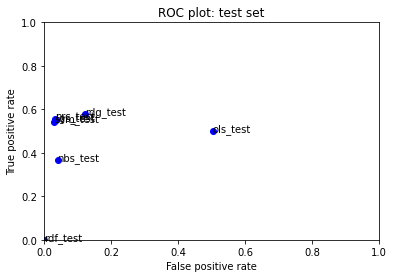

In [74]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [75]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6      

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [76]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5052623331853439


In [77]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [78]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,False
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [79]:
my_submission.shape

(153164, 2)

In [80]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation